## <center> Bài tập Biến hình và Xử lý ảnh </center>

Họ và Tên: Huỳnh Nguyễn Thế Dân

MSSV: 21110256

Lớp: 21TTH1

<h1><center> Lab03_IS_Introduction to Deep Learning </center> </h1>


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# MNIST dataset

In [3]:
ROOT = 'data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066048920154572
Calculated std: 0.30810779333114624


--------
## Useful Functions



In [5]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

### Define model

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [7]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [8]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [9]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [10]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [11]:
def process_data(add_transform, show_img = True, mean=mean, std=std):

  train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            *add_transform,

                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

  train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

  print(f'Number of training examples: {len(train_data)}')

  test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

  test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

  print(f'Number of testing examples: {len(test_data)}')

  if show_img:
    N_IMAGES = 25
    images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
    plot_images(images)

  VALID_RATIO = 0.9

  n_train_examples = int(len(train_data) * VALID_RATIO)
  n_valid_examples = len(train_data) - n_train_examples

  train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
  valid_data = copy.deepcopy(valid_data)
  valid_data.dataset.transform = test_transforms

  return train_data, valid_data, test_data

In [12]:
def load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 64):

  train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

  valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

  test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

  return train_iterator, valid_iterator, test_iterator

In [13]:
def train_model(model, train_iterator, valid_iterator, EPOCHS = 10):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  best_valid_loss = float('inf')
  optimizer = optim.Adam(model.parameters())
  criterion = nn.CrossEntropyLoss()
  model = model.to(device)
  criterion = criterion.to(device)

  for epoch in trange(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [14]:
def test_model(model, test_iterator):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = nn.CrossEntropyLoss().to(device)
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
  return round(test_loss, 3), round(test_acc*100, 2)


---------

## Train model với Batch size = 64, Activation: Relu

In [15]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

Number of training examples: 60000
Number of testing examples: 10000


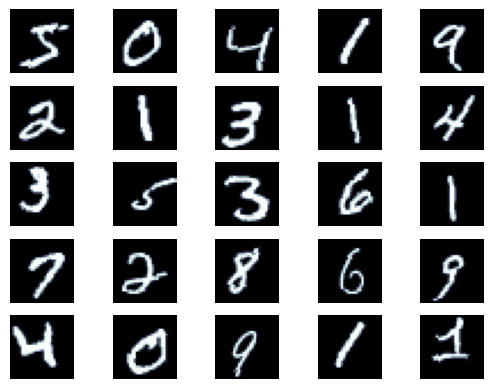

In [16]:
# Augmentation
add_transform = []
train_data, valid_data, test_data = process_data(add_transform)

Number of training examples: 60000
Number of testing examples: 10000


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.413 | Train Acc: 87.13%
	 Val. Loss: 0.142 |  Val. Acc: 95.67%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.170 | Train Acc: 94.65%
	 Val. Loss: 0.108 |  Val. Acc: 96.46%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.142 | Train Acc: 95.54%
	 Val. Loss: 0.082 |  Val. Acc: 97.58%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.119 | Train Acc: 96.20%
	 Val. Loss: 0.082 |  Val. Acc: 97.54%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.108 | Train Acc: 96.59%
	 Val. Loss: 0.080 |  Val. Acc: 97.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.103 | Train Acc: 96.80%
	 Val. Loss: 0.069 |  Val. Acc: 98.01%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.092 | Train Acc: 97.05%
	 Val. Loss: 0.060 |  Val. Acc: 98.30%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.086 | Train Acc: 97.28%
	 Val. Loss: 0.062 |  Val. Acc: 98.22%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.083 | Train Acc: 97.41%
	 Val. Loss: 0.061 |  Val. Acc: 98.01%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 0.081 | Train Acc: 97.44%
	 Val. Loss: 0.057 |  Val. Acc: 98.22%


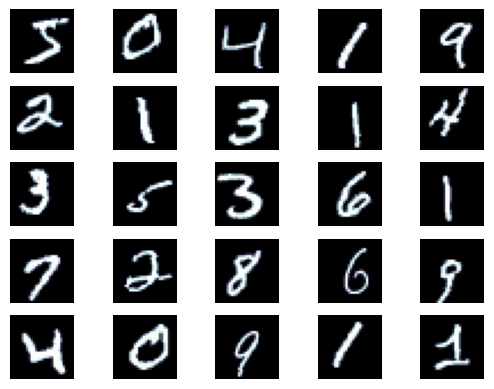

In [17]:
# Train model
train_data, valid_data, test_data = process_data(add_transform)
train_iterator, valid_iterator, test_iterator = load_DataLoader(train_data, valid_data, test_data)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator, valid_iterator)

In [18]:
test_loss, test_acc = test_model(model, test_iterator)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.056 | Test Acc: 98.17%


## Thêm phần tạo đa dang data Augmentation với `RandomHorizontalFlip`

Number of training examples: 60000
Number of testing examples: 10000


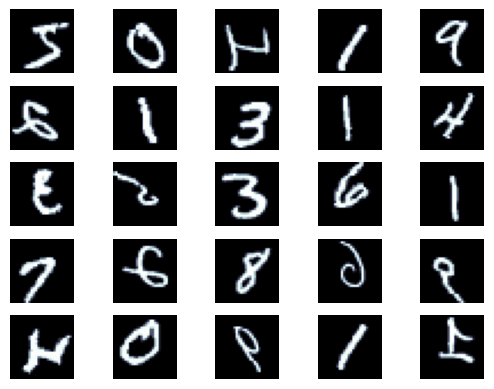

In [19]:
# Augmentation
add_transform = [transforms.RandomHorizontalFlip()]
train_data_Flip, valid_data_Flip, test_data_Flip = process_data(add_transform)

In [20]:
# Train model
train_iterator_Flip, valid_iterator_Flip, test_iterator_Flip = load_DataLoader(train_data_Flip, valid_data_Flip, test_data_Flip)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_Flip, valid_iterator_Flip)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.594 | Train Acc: 80.58%
	 Val. Loss: 0.269 |  Val. Acc: 91.26%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.303 | Train Acc: 90.30%
	 Val. Loss: 0.210 |  Val. Acc: 93.15%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.248 | Train Acc: 92.15%
	 Val. Loss: 0.183 |  Val. Acc: 94.04%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.221 | Train Acc: 92.95%
	 Val. Loss: 0.174 |  Val. Acc: 94.41%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.202 | Train Acc: 93.46%
	 Val. Loss: 0.167 |  Val. Acc: 94.34%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 0.188 | Train Acc: 93.92%
	 Val. Loss: 0.213 |  Val. Acc: 92.90%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.180 | Train Acc: 94.22%
	 Val. Loss: 0.149 |  Val. Acc: 94.95%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.166 | Train Acc: 94.69%
	 Val. Loss: 0.128 |  Val. Acc: 96.09%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.163 | Train Acc: 94.85%
	 Val. Loss: 0.144 |  Val. Acc: 95.28%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 24s
	Train Loss: 0.158 | Train Acc: 94.89%
	 Val. Loss: 0.129 |  Val. Acc: 95.81%


In [21]:
test_loss_Flip, test_acc_Flip = test_model(model, test_iterator_Flip)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.114 | Test Acc: 96.24%


## Thêm phần tạo đa dạng data Augmentation với `RandomZoomOut`

Number of training examples: 60000
Number of testing examples: 10000


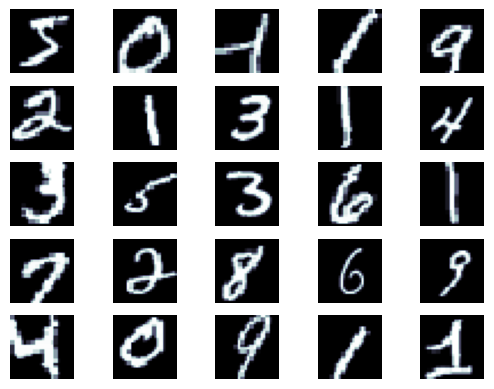

In [22]:
# Augmentation
add_transform = [transforms.RandomAffine(degrees=0, scale=(1.0, 1.5))]
train_data_ZoomOut, valid_data_ZoomOut, test_data_ZoomOut = process_data(add_transform)

In [23]:
# Train model
train_iterator_ZoomOut, valid_iterator_ZoomOut, test_iterator_ZoomOut = load_DataLoader(train_data_ZoomOut, valid_data_ZoomOut, test_data_ZoomOut)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_ZoomOut, valid_iterator_ZoomOut)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.433 | Train Acc: 86.59%
	 Val. Loss: 0.197 |  Val. Acc: 93.95%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.193 | Train Acc: 94.09%
	 Val. Loss: 0.141 |  Val. Acc: 95.89%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.158 | Train Acc: 95.08%
	 Val. Loss: 0.111 |  Val. Acc: 96.35%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.139 | Train Acc: 95.70%
	 Val. Loss: 0.111 |  Val. Acc: 96.55%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.127 | Train Acc: 95.98%
	 Val. Loss: 0.110 |  Val. Acc: 96.38%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.120 | Train Acc: 96.21%
	 Val. Loss: 0.096 |  Val. Acc: 97.00%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.110 | Train Acc: 96.62%
	 Val. Loss: 0.085 |  Val. Acc: 97.29%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.108 | Train Acc: 96.64%
	 Val. Loss: 0.085 |  Val. Acc: 97.46%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 0.102 | Train Acc: 96.86%
	 Val. Loss: 0.072 |  Val. Acc: 97.85%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.101 | Train Acc: 96.92%
	 Val. Loss: 0.086 |  Val. Acc: 97.26%


In [24]:
test_loss_ZoomOut, test_acc_ZoomOut = test_model(model, test_iterator_ZoomOut)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.083 | Test Acc: 97.36%


## Thêm phần tạo đa dang data Augmentation với `RandomAffine `

Number of training examples: 60000
Number of testing examples: 10000


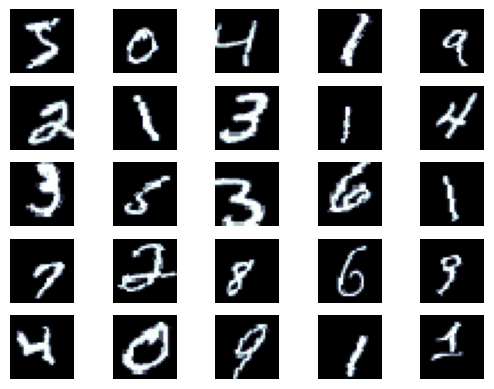

In [25]:
# Augmentation
add_transform = [transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10)]
train_data_Affine, valid_data_Affine, test_data_Affine = process_data(add_transform)

In [26]:
# Train model
train_iterator_Affine, valid_iterator_Affine, test_iterator_Affine = load_DataLoader(train_data_Affine, valid_data_Affine, test_data_Affine)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_Affine, valid_iterator_Affine)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.625 | Train Acc: 80.05%
	 Val. Loss: 0.214 |  Val. Acc: 94.13%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.293 | Train Acc: 90.85%
	 Val. Loss: 0.143 |  Val. Acc: 95.72%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.235 | Train Acc: 92.55%
	 Val. Loss: 0.118 |  Val. Acc: 96.42%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.206 | Train Acc: 93.50%
	 Val. Loss: 0.102 |  Val. Acc: 96.89%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.189 | Train Acc: 94.05%
	 Val. Loss: 0.089 |  Val. Acc: 97.20%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.177 | Train Acc: 94.42%
	 Val. Loss: 0.087 |  Val. Acc: 97.33%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.166 | Train Acc: 94.76%
	 Val. Loss: 0.086 |  Val. Acc: 97.33%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 26s
	Train Loss: 0.158 | Train Acc: 95.01%
	 Val. Loss: 0.074 |  Val. Acc: 97.53%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 0.155 | Train Acc: 95.03%
	 Val. Loss: 0.080 |  Val. Acc: 97.46%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 26s
	Train Loss: 0.150 | Train Acc: 95.35%
	 Val. Loss: 0.071 |  Val. Acc: 97.92%


In [27]:
test_loss_Affine, test_acc_Affine = test_model(model, test_iterator_Affine)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.062 | Test Acc: 97.85%


## Thay đổi Batch Size = 32

In [28]:
# Train model
train_iterator_32, valid_iterator_32, test_iterator_32 = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 32)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_32, valid_iterator_32)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.357 | Train Acc: 88.79%
	 Val. Loss: 0.135 |  Val. Acc: 95.74%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.168 | Train Acc: 94.84%
	 Val. Loss: 0.098 |  Val. Acc: 97.17%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 0.136 | Train Acc: 95.74%
	 Val. Loss: 0.078 |  Val. Acc: 97.47%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.119 | Train Acc: 96.35%
	 Val. Loss: 0.072 |  Val. Acc: 97.74%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.109 | Train Acc: 96.67%
	 Val. Loss: 0.066 |  Val. Acc: 97.96%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.102 | Train Acc: 96.78%
	 Val. Loss: 0.068 |  Val. Acc: 97.97%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 26s
	Train Loss: 0.094 | Train Acc: 97.09%
	 Val. Loss: 0.069 |  Val. Acc: 97.67%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 26s
	Train Loss: 0.091 | Train Acc: 97.18%
	 Val. Loss: 0.069 |  Val. Acc: 97.87%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 0.089 | Train Acc: 97.25%
	 Val. Loss: 0.062 |  Val. Acc: 98.25%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 26s
	Train Loss: 0.084 | Train Acc: 97.36%
	 Val. Loss: 0.065 |  Val. Acc: 98.11%


In [29]:
test_loss_32, test_acc_32 = test_model(model, test_iterator_32)

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.060 | Test Acc: 98.29%


## Thay đổi Batch Size = 128

In [30]:
# Train model
train_iterator_128, valid_iterator_128, test_iterator_128 = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 128)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_128, valid_iterator_128)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.486 | Train Acc: 85.02%
	 Val. Loss: 0.184 |  Val. Acc: 94.53%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.188 | Train Acc: 94.33%
	 Val. Loss: 0.120 |  Val. Acc: 96.30%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 0.143 | Train Acc: 95.62%
	 Val. Loss: 0.089 |  Val. Acc: 97.50%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.124 | Train Acc: 96.12%
	 Val. Loss: 0.083 |  Val. Acc: 97.48%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 0.110 | Train Acc: 96.55%
	 Val. Loss: 0.074 |  Val. Acc: 97.63%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.104 | Train Acc: 96.79%
	 Val. Loss: 0.068 |  Val. Acc: 97.95%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.093 | Train Acc: 97.09%
	 Val. Loss: 0.061 |  Val. Acc: 98.11%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 0.090 | Train Acc: 97.18%
	 Val. Loss: 0.060 |  Val. Acc: 98.23%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 0.083 | Train Acc: 97.45%
	 Val. Loss: 0.061 |  Val. Acc: 98.22%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 20s
	Train Loss: 0.080 | Train Acc: 97.50%
	 Val. Loss: 0.062 |  Val. Acc: 98.05%


In [31]:
test_loss_128, test_acc_128 = test_model(model, test_iterator_128)

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.059 | Test Acc: 98.04%


## Thay đổi Batch Size = 256

In [32]:
# Train model
train_iterator_256, valid_iterator_256, test_iterator_256 = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 256)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_256, valid_iterator_256)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.613 | Train Acc: 81.22%
	 Val. Loss: 0.189 |  Val. Acc: 94.34%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.212 | Train Acc: 93.66%
	 Val. Loss: 0.126 |  Val. Acc: 96.05%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.160 | Train Acc: 95.21%
	 Val. Loss: 0.112 |  Val. Acc: 96.64%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.136 | Train Acc: 95.83%
	 Val. Loss: 0.104 |  Val. Acc: 96.80%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.121 | Train Acc: 96.24%
	 Val. Loss: 0.079 |  Val. Acc: 97.41%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.110 | Train Acc: 96.58%
	 Val. Loss: 0.077 |  Val. Acc: 97.70%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.098 | Train Acc: 96.89%
	 Val. Loss: 0.077 |  Val. Acc: 97.64%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.094 | Train Acc: 97.07%
	 Val. Loss: 0.059 |  Val. Acc: 98.07%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.088 | Train Acc: 97.24%
	 Val. Loss: 0.059 |  Val. Acc: 98.01%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 19s
	Train Loss: 0.083 | Train Acc: 97.43%
	 Val. Loss: 0.058 |  Val. Acc: 98.29%


In [33]:
test_loss_256, test_acc_256 = test_model(model, test_iterator_256)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.053 | Test Acc: 98.27%


## Đổi hành Activation :  LeakyRelu

In [34]:
class MLP_LeakyRelu(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.leaky_relu(self.input_fc(x), negative_slope=0.2)
        h_2 = F.leaky_relu(self.hidden_fc(h_1), negative_slope=0.2)
        y_pred = self.output_fc(h_2)

        return y_pred, h_2

In [35]:
# Train model
train_iterator_LeakyRelu, valid_iterator_LeakyRelu, test_iterator_LeakyRelu = load_DataLoader(train_data, valid_data, test_data)
model_LeakyRelu = MLP_LeakyRelu(INPUT_DIM, OUTPUT_DIM)
train_model(model_LeakyRelu, train_iterator_LeakyRelu, valid_iterator_LeakyRelu)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 0.457 | Train Acc: 85.73%
	 Val. Loss: 0.172 |  Val. Acc: 94.54%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.199 | Train Acc: 93.91%
	 Val. Loss: 0.113 |  Val. Acc: 96.88%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.165 | Train Acc: 94.98%
	 Val. Loss: 0.106 |  Val. Acc: 96.66%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 0.147 | Train Acc: 95.53%
	 Val. Loss: 0.083 |  Val. Acc: 97.39%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 0.127 | Train Acc: 96.08%
	 Val. Loss: 0.089 |  Val. Acc: 97.33%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.126 | Train Acc: 96.14%
	 Val. Loss: 0.076 |  Val. Acc: 97.73%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.115 | Train Acc: 96.41%
	 Val. Loss: 0.079 |  Val. Acc: 97.64%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.110 | Train Acc: 96.58%
	 Val. Loss: 0.091 |  Val. Acc: 97.24%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.105 | Train Acc: 96.77%
	 Val. Loss: 0.082 |  Val. Acc: 97.32%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 0.102 | Train Acc: 96.88%
	 Val. Loss: 0.078 |  Val. Acc: 97.65%


In [36]:
test_loss_LeakyRelu, test_acc_LeakyRelu = test_model(model_LeakyRelu, test_iterator_LeakyRelu)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.070 | Test Acc: 97.68%


## Đổi hành Activation :  ELU

In [37]:
class MLP_ELU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.elu(self.input_fc(x), alpha=1.0)
        h_2 = F.elu(self.hidden_fc(h_1), alpha=1.0)
        y_pred = self.output_fc(h_2)

        return y_pred, h_2

In [38]:
# Train model
train_iterator_ELU, valid_iterator_ELU, test_iterator_ELU = load_DataLoader(train_data, valid_data, test_data)
model_ELU = MLP_ELU(INPUT_DIM, OUTPUT_DIM)
train_model(model_ELU, train_iterator_ELU, valid_iterator_ELU)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 0.422 | Train Acc: 86.70%
	 Val. Loss: 0.133 |  Val. Acc: 95.90%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 0.165 | Train Acc: 94.82%
	 Val. Loss: 0.114 |  Val. Acc: 96.65%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 0.126 | Train Acc: 96.02%
	 Val. Loss: 0.082 |  Val. Acc: 97.50%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 0.112 | Train Acc: 96.47%
	 Val. Loss: 0.081 |  Val. Acc: 97.41%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.100 | Train Acc: 96.90%
	 Val. Loss: 0.065 |  Val. Acc: 98.08%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.095 | Train Acc: 97.01%
	 Val. Loss: 0.065 |  Val. Acc: 97.95%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.084 | Train Acc: 97.34%
	 Val. Loss: 0.063 |  Val. Acc: 97.96%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 0.084 | Train Acc: 97.37%
	 Val. Loss: 0.065 |  Val. Acc: 97.98%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 0.078 | Train Acc: 97.48%
	 Val. Loss: 0.050 |  Val. Acc: 98.30%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 23s
	Train Loss: 0.074 | Train Acc: 97.70%
	 Val. Loss: 0.053 |  Val. Acc: 98.45%


In [39]:
test_loss_ELU, test_acc_ELU = test_model(model_ELU, test_iterator_ELU)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.059 | Test Acc: 97.99%


## Tạo bảng so sánh (MNIST dataset)

In [40]:
from tabulate import tabulate

data_header = ['Model with', 'Test_loss', 'Test_acc']
data_values = [
      ['Batch size = 64 + RELU', test_loss, test_acc],
      ['RandomHorizontalFlip', test_loss_Flip, test_acc_Flip],
      ['RandomZoomOut', test_loss_ZoomOut, test_acc_ZoomOut],
      ['RandomAffine', test_loss_Affine, test_acc_Affine],
      ['Batch size = 32', test_loss_32, test_acc_32],
      ['Batch size = 128', test_loss_128, test_acc_128],
      ['Batch size = 256', test_loss_256, test_acc_256],
      ['LeakyRelu', test_loss_LeakyRelu, test_acc_LeakyRelu],
      ['ELU', test_loss_ELU, test_acc_ELU]

]

In [41]:
# Generate the table
result = tabulate(
data_values,
headers=data_header,
tablefmt='fancy_grid',
)
# Print the resulting table
print(result)


╒════════════════════════╤═════════════╤════════════╕
│ Model with             │   Test_loss │   Test_acc │
╞════════════════════════╪═════════════╪════════════╡
│ Batch size = 64 + RELU │       0.056 │      98.17 │
├────────────────────────┼─────────────┼────────────┤
│ RandomHorizontalFlip   │       0.114 │      96.24 │
├────────────────────────┼─────────────┼────────────┤
│ RandomZoomOut          │       0.083 │      97.36 │
├────────────────────────┼─────────────┼────────────┤
│ RandomAffine           │       0.062 │      97.85 │
├────────────────────────┼─────────────┼────────────┤
│ Batch size = 32        │       0.06  │      98.29 │
├────────────────────────┼─────────────┼────────────┤
│ Batch size = 128       │       0.059 │      98.04 │
├────────────────────────┼─────────────┼────────────┤
│ Batch size = 256       │       0.053 │      98.27 │
├────────────────────────┼─────────────┼────────────┤
│ LeakyRelu              │       0.07  │      97.68 │
├────────────────────────┼──

# CIFAR10 dataset

In [42]:
ROOT = 'data'

train_data_cifar10 = datasets.CIFAR10(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 170498071/170498071 [00:20<00:00, 8247125.15it/s] 


Extracting data\cifar-10-python.tar.gz to data


In [43]:
mean_cifar10 = train_data_cifar10.data.mean() / 255
std_cifar10 = train_data_cifar10.data.std() / 255
print(f'Calculated mean: {mean_cifar10}')
print(f'Calculated std: {std_cifar10}')

Calculated mean: 0.4733630004850899
Calculated std: 0.2515689250632208


In [44]:
def process_data_cifar10(add_transform, mean=mean_cifar10, std=std_cifar10):

  train_transforms = transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            *add_transform,

                            transforms.Resize((28, 28)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

  train_data = datasets.CIFAR10(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

  print(f'Number of training examples: {len(train_data)}')

  test_transforms = transforms.Compose([
                           transforms.Grayscale(num_output_channels=1),
                           transforms.Resize((28, 28)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

  test_data = datasets.CIFAR10(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

  print(f'Number of testing examples: {len(test_data)}')

  N_IMAGES = 25
  images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
  plot_images(images)

  VALID_RATIO = 0.9

  n_train_examples = int(len(train_data) * VALID_RATIO)
  n_valid_examples = len(train_data) - n_train_examples

  train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
  valid_data = copy.deepcopy(valid_data)
  valid_data.dataset.transform = test_transforms

  return train_data, valid_data, test_data

## Train model với Batch size = 64, Activation: Relu

In [45]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

Files already downloaded and verified
Number of training examples: 50000
Files already downloaded and verified
Number of testing examples: 10000


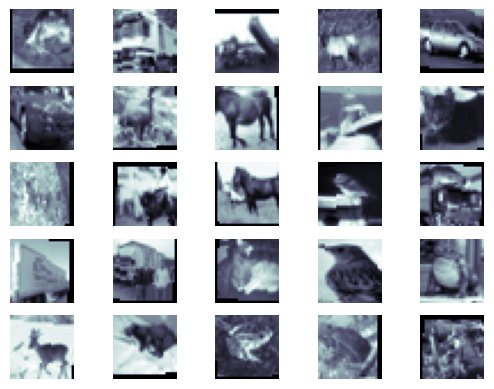

In [46]:
# Augmentation
add_transform = []
train_data, valid_data, test_data = process_data_cifar10(add_transform)

In [47]:
# Train model
train_iterator, valid_iterator, test_iterator = load_DataLoader(train_data, valid_data, test_data)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator, valid_iterator)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 2.011 | Train Acc: 27.29%
	 Val. Loss: 1.902 |  Val. Acc: 31.98%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 1.881 | Train Acc: 32.69%
	 Val. Loss: 1.814 |  Val. Acc: 36.51%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 1.825 | Train Acc: 34.94%
	 Val. Loss: 1.791 |  Val. Acc: 36.73%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 1.784 | Train Acc: 36.58%
	 Val. Loss: 1.765 |  Val. Acc: 37.56%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 1.760 | Train Acc: 37.38%
	 Val. Loss: 1.731 |  Val. Acc: 38.27%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 1.743 | Train Acc: 37.78%
	 Val. Loss: 1.711 |  Val. Acc: 39.38%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 1.722 | Train Acc: 38.54%
	 Val. Loss: 1.690 |  Val. Acc: 39.85%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 1.706 | Train Acc: 39.02%
	 Val. Loss: 1.708 |  Val. Acc: 38.88%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 20s
	Train Loss: 1.692 | Train Acc: 39.96%
	 Val. Loss: 1.710 |  Val. Acc: 40.05%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 20s
	Train Loss: 1.682 | Train Acc: 40.04%
	 Val. Loss: 1.699 |  Val. Acc: 40.25%


In [48]:
test_loss, test_acc = test_model(model, test_iterator)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.685 | Test Acc: 40.60%


## Thêm phần tạo đa dang data Augmentation với `RandomHorizontalFlip`

Files already downloaded and verified
Number of training examples: 50000
Files already downloaded and verified
Number of testing examples: 10000


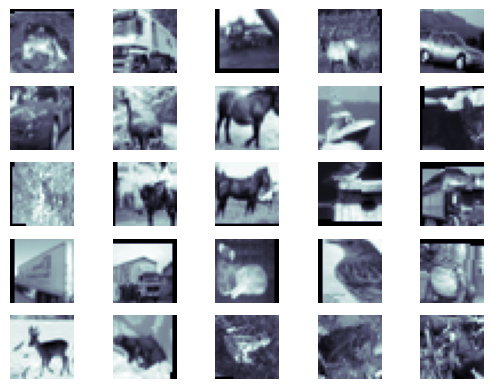

In [49]:
# Augmentation
add_transform = [transforms.RandomHorizontalFlip()]
train_data_Flip, valid_data_Flip, test_data_Flip = process_data_cifar10(add_transform)

In [50]:
# Train model
train_iterator_Flip, valid_iterator_Flip, test_iterator_Flip = load_DataLoader(train_data_Flip, valid_data_Flip, test_data_Flip)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_Flip, valid_iterator_Flip)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 2.010 | Train Acc: 27.74%
	 Val. Loss: 1.887 |  Val. Acc: 32.46%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.881 | Train Acc: 32.86%
	 Val. Loss: 1.831 |  Val. Acc: 35.70%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 1.828 | Train Acc: 34.54%
	 Val. Loss: 1.766 |  Val. Acc: 38.29%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 1.794 | Train Acc: 35.69%
	 Val. Loss: 1.750 |  Val. Acc: 37.92%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 1.771 | Train Acc: 36.40%
	 Val. Loss: 1.742 |  Val. Acc: 38.98%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.750 | Train Acc: 37.70%
	 Val. Loss: 1.709 |  Val. Acc: 39.72%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 1.733 | Train Acc: 38.17%
	 Val. Loss: 1.718 |  Val. Acc: 40.84%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 1.715 | Train Acc: 38.85%
	 Val. Loss: 1.694 |  Val. Acc: 39.24%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.705 | Train Acc: 39.04%
	 Val. Loss: 1.667 |  Val. Acc: 40.72%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 1.698 | Train Acc: 39.28%
	 Val. Loss: 1.666 |  Val. Acc: 41.69%


In [51]:
test_loss_Flip, test_acc_Flip = test_model(model, test_iterator_Flip)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.662 | Test Acc: 40.96%


## Thêm phần tạo đa dang data Augmentation với `RandomZoomOut`

Files already downloaded and verified
Number of training examples: 50000
Files already downloaded and verified
Number of testing examples: 10000


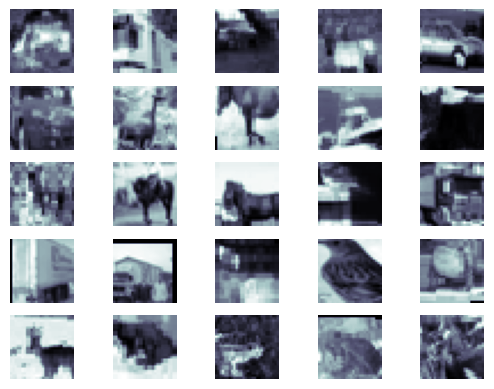

In [52]:
# Augmentation
add_transform = [transforms.RandomAffine(degrees=0, scale=(1.0, 1.5))]
train_data_ZoomOut, valid_data_ZoomOut, test_data_ZoomOut = process_data_cifar10(add_transform)

In [53]:
# Train model
train_iterator_ZoomOut, valid_iterator_ZoomOut, test_iterator_ZoomOut = load_DataLoader(train_data_ZoomOut, valid_data_ZoomOut, test_data_ZoomOut)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_ZoomOut, valid_iterator_ZoomOut)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 2.063 | Train Acc: 25.33%
	 Val. Loss: 1.983 |  Val. Acc: 28.90%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.968 | Train Acc: 29.57%
	 Val. Loss: 1.924 |  Val. Acc: 31.47%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.918 | Train Acc: 31.04%
	 Val. Loss: 1.869 |  Val. Acc: 32.52%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.888 | Train Acc: 32.46%
	 Val. Loss: 1.866 |  Val. Acc: 34.26%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.862 | Train Acc: 33.16%
	 Val. Loss: 1.843 |  Val. Acc: 34.20%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.843 | Train Acc: 34.02%
	 Val. Loss: 1.829 |  Val. Acc: 34.06%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.823 | Train Acc: 34.89%
	 Val. Loss: 1.811 |  Val. Acc: 35.34%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.810 | Train Acc: 35.15%
	 Val. Loss: 1.784 |  Val. Acc: 36.43%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.800 | Train Acc: 35.49%
	 Val. Loss: 1.763 |  Val. Acc: 38.43%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 23s
	Train Loss: 1.783 | Train Acc: 36.21%
	 Val. Loss: 1.752 |  Val. Acc: 38.25%


In [54]:
test_loss_ZoomOut, test_acc_ZoomOut = test_model(model, test_iterator_ZoomOut)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.762 | Test Acc: 38.25%


## Thêm phần tạo đa dang data Augmentation với `RandomAffine `

Files already downloaded and verified
Number of training examples: 50000
Files already downloaded and verified
Number of testing examples: 10000


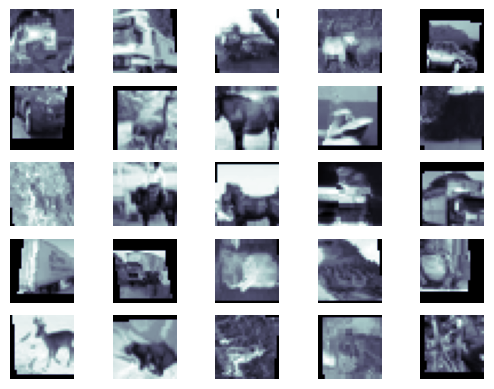

In [55]:
# Augmentation
add_transform = [transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10)]
train_data_Affine, valid_data_Affine, test_data_Affine = process_data_cifar10(add_transform)

In [56]:
# Train model
train_iterator_Affine, valid_iterator_Affine, test_iterator_Affine = load_DataLoader(train_data_Affine, valid_data_Affine, test_data_Affine)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_Affine, valid_iterator_Affine)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 2.111 | Train Acc: 22.80%
	 Val. Loss: 1.997 |  Val. Acc: 28.66%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 2.014 | Train Acc: 26.95%
	 Val. Loss: 1.918 |  Val. Acc: 32.08%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 1.970 | Train Acc: 28.69%
	 Val. Loss: 1.909 |  Val. Acc: 31.96%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 1.938 | Train Acc: 30.04%
	 Val. Loss: 1.874 |  Val. Acc: 34.06%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 1.912 | Train Acc: 30.98%
	 Val. Loss: 1.864 |  Val. Acc: 34.47%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 1.898 | Train Acc: 31.41%
	 Val. Loss: 1.825 |  Val. Acc: 35.30%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 1.882 | Train Acc: 31.92%
	 Val. Loss: 1.890 |  Val. Acc: 33.54%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 1.871 | Train Acc: 32.53%
	 Val. Loss: 1.792 |  Val. Acc: 36.89%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 1.860 | Train Acc: 33.05%
	 Val. Loss: 1.848 |  Val. Acc: 34.77%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 29s
	Train Loss: 1.854 | Train Acc: 33.16%
	 Val. Loss: 1.796 |  Val. Acc: 36.85%


In [57]:
test_loss_Affine, test_acc_Affine = test_model(model, test_iterator_Affine)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.808 | Test Acc: 36.18%


## Thay đổi Batch Size = 32

In [58]:
# Train model
train_iterator_32, valid_iterator_32, test_iterator_32 = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 32)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_32, valid_iterator_32)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 2.011 | Train Acc: 27.50%
	 Val. Loss: 1.902 |  Val. Acc: 32.70%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 1.889 | Train Acc: 32.49%
	 Val. Loss: 1.823 |  Val. Acc: 34.95%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 1.842 | Train Acc: 34.44%
	 Val. Loss: 1.802 |  Val. Acc: 36.13%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 1.809 | Train Acc: 35.39%
	 Val. Loss: 1.783 |  Val. Acc: 36.58%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 1.785 | Train Acc: 36.23%
	 Val. Loss: 1.780 |  Val. Acc: 36.98%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 1.770 | Train Acc: 36.79%
	 Val. Loss: 1.743 |  Val. Acc: 37.60%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 1.752 | Train Acc: 37.58%
	 Val. Loss: 1.727 |  Val. Acc: 38.91%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 1.737 | Train Acc: 37.90%
	 Val. Loss: 1.731 |  Val. Acc: 38.91%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 1.722 | Train Acc: 38.58%
	 Val. Loss: 1.696 |  Val. Acc: 40.09%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 28s
	Train Loss: 1.716 | Train Acc: 38.91%
	 Val. Loss: 1.697 |  Val. Acc: 39.83%


In [59]:
test_loss_32, test_acc_32 = test_model(model, test_iterator_32)

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 1.689 | Test Acc: 40.25%


## Thay đổi Batch Size = 128

In [60]:
# Train model
train_iterator_128, valid_iterator_128, test_iterator_128 = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 128)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_128, valid_iterator_128)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 2.019 | Train Acc: 27.23%
	 Val. Loss: 1.875 |  Val. Acc: 33.01%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 1.884 | Train Acc: 32.75%
	 Val. Loss: 1.805 |  Val. Acc: 35.70%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 1.820 | Train Acc: 34.89%
	 Val. Loss: 1.785 |  Val. Acc: 36.13%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 1.783 | Train Acc: 36.28%
	 Val. Loss: 1.739 |  Val. Acc: 38.34%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 1.755 | Train Acc: 37.71%
	 Val. Loss: 1.723 |  Val. Acc: 38.69%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 1.734 | Train Acc: 38.28%
	 Val. Loss: 1.699 |  Val. Acc: 39.71%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 1.712 | Train Acc: 39.20%
	 Val. Loss: 1.671 |  Val. Acc: 40.35%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 1.702 | Train Acc: 39.33%
	 Val. Loss: 1.663 |  Val. Acc: 41.11%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 1.688 | Train Acc: 39.83%
	 Val. Loss: 1.654 |  Val. Acc: 41.70%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 1.672 | Train Acc: 40.70%
	 Val. Loss: 1.646 |  Val. Acc: 42.05%


In [61]:
test_loss_128, test_acc_128 = test_model(model, test_iterator_128)

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.634 | Test Acc: 42.24%


## Thay đổi Batch Size = 256

In [62]:
# Train model
train_iterator_256, valid_iterator_256, test_iterator_256 = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 256)
model = MLP(INPUT_DIM, OUTPUT_DIM)
train_model(model, train_iterator_256, valid_iterator_256)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 2.033 | Train Acc: 26.47%
	 Val. Loss: 1.900 |  Val. Acc: 31.66%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 1.895 | Train Acc: 32.53%
	 Val. Loss: 1.839 |  Val. Acc: 34.78%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 1.833 | Train Acc: 34.95%
	 Val. Loss: 1.795 |  Val. Acc: 36.72%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 1.792 | Train Acc: 36.42%
	 Val. Loss: 1.781 |  Val. Acc: 36.43%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 1.763 | Train Acc: 37.31%
	 Val. Loss: 1.721 |  Val. Acc: 38.51%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 1.738 | Train Acc: 38.30%
	 Val. Loss: 1.713 |  Val. Acc: 39.63%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 1.716 | Train Acc: 38.91%
	 Val. Loss: 1.705 |  Val. Acc: 39.14%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 1.705 | Train Acc: 39.31%
	 Val. Loss: 1.658 |  Val. Acc: 40.88%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 1.687 | Train Acc: 39.88%
	 Val. Loss: 1.643 |  Val. Acc: 41.89%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 20s
	Train Loss: 1.669 | Train Acc: 40.68%
	 Val. Loss: 1.649 |  Val. Acc: 41.28%


In [63]:
test_loss_256, test_acc_256 = test_model(model, test_iterator_256)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.648 | Test Acc: 41.12%


## Đổi hành Activation :  LeakyRelu

In [64]:
# Train model
train_iterator_LeakyRelu, valid_iterator_LeakyRelu, test_iterator_LeakyRelu = load_DataLoader(train_data, valid_data, test_data)
model_LeakyRelu = MLP_LeakyRelu(INPUT_DIM, OUTPUT_DIM)
train_model(model_LeakyRelu, train_iterator_LeakyRelu, valid_iterator_LeakyRelu)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 2.034 | Train Acc: 26.67%
	 Val. Loss: 1.925 |  Val. Acc: 30.85%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 1.907 | Train Acc: 31.82%
	 Val. Loss: 1.838 |  Val. Acc: 34.32%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 1.854 | Train Acc: 33.89%
	 Val. Loss: 1.791 |  Val. Acc: 37.36%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 1.823 | Train Acc: 35.09%
	 Val. Loss: 1.755 |  Val. Acc: 38.01%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 1.801 | Train Acc: 35.84%
	 Val. Loss: 1.762 |  Val. Acc: 37.22%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 39s
	Train Loss: 1.781 | Train Acc: 36.49%
	 Val. Loss: 1.762 |  Val. Acc: 37.80%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 34s
	Train Loss: 1.766 | Train Acc: 36.95%
	 Val. Loss: 1.702 |  Val. Acc: 39.56%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 31s
	Train Loss: 1.744 | Train Acc: 37.67%
	 Val. Loss: 1.721 |  Val. Acc: 38.47%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 1.739 | Train Acc: 38.17%
	 Val. Loss: 1.710 |  Val. Acc: 40.39%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 32s
	Train Loss: 1.726 | Train Acc: 38.18%
	 Val. Loss: 1.662 |  Val. Acc: 40.92%


In [65]:
test_loss_LeakyRelu, test_acc_LeakyRelu = test_model(model_LeakyRelu, test_iterator_LeakyRelu)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.648 | Test Acc: 41.31%


## Đổi hành Activation :  ELU

In [66]:
# Train model
train_iterator_ELU, valid_iterator_ELU, test_iterator_ELU = load_DataLoader(train_data, valid_data, test_data)
model_ELU = MLP_ELU(INPUT_DIM, OUTPUT_DIM)
train_model(model_ELU, train_iterator_ELU, valid_iterator_ELU)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 2.016 | Train Acc: 27.22%
	 Val. Loss: 1.863 |  Val. Acc: 32.50%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 1.862 | Train Acc: 33.04%
	 Val. Loss: 1.763 |  Val. Acc: 37.30%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 1.802 | Train Acc: 35.31%
	 Val. Loss: 1.744 |  Val. Acc: 37.80%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 1.769 | Train Acc: 36.74%
	 Val. Loss: 1.699 |  Val. Acc: 39.16%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 1.744 | Train Acc: 37.45%
	 Val. Loss: 1.684 |  Val. Acc: 39.72%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 1.721 | Train Acc: 38.30%
	 Val. Loss: 1.674 |  Val. Acc: 41.00%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 1.701 | Train Acc: 38.82%
	 Val. Loss: 1.676 |  Val. Acc: 40.82%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 1.685 | Train Acc: 39.69%
	 Val. Loss: 1.650 |  Val. Acc: 41.57%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 1.676 | Train Acc: 39.87%
	 Val. Loss: 1.635 |  Val. Acc: 42.17%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 31s
	Train Loss: 1.660 | Train Acc: 40.66%
	 Val. Loss: 1.614 |  Val. Acc: 41.38%


In [67]:
test_loss_ELU, test_acc_ELU = test_model(model_ELU, test_iterator_ELU)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.631 | Test Acc: 42.42%


### Combine Batch Size 128 + ELU

In [68]:
# Train model
train_iterator_128_ELU, valid_iterator_128_ELU, test_iterator_128_ELU = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 128)
model_ELU = MLP_ELU(INPUT_DIM, OUTPUT_DIM)
train_model(model_ELU, train_iterator_128_ELU, valid_iterator_128_ELU)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 2.028 | Train Acc: 26.95%
	 Val. Loss: 1.882 |  Val. Acc: 33.46%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 1.885 | Train Acc: 32.21%
	 Val. Loss: 1.813 |  Val. Acc: 34.55%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 1.812 | Train Acc: 35.28%
	 Val. Loss: 1.730 |  Val. Acc: 37.87%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 1.772 | Train Acc: 36.33%
	 Val. Loss: 1.706 |  Val. Acc: 38.26%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 30s
	Train Loss: 1.740 | Train Acc: 37.59%
	 Val. Loss: 1.691 |  Val. Acc: 39.49%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 1.724 | Train Acc: 38.31%
	 Val. Loss: 1.671 |  Val. Acc: 39.75%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 1.703 | Train Acc: 38.97%
	 Val. Loss: 1.660 |  Val. Acc: 41.23%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 29s
	Train Loss: 1.686 | Train Acc: 39.74%
	 Val. Loss: 1.638 |  Val. Acc: 41.68%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 1.675 | Train Acc: 40.23%
	 Val. Loss: 1.650 |  Val. Acc: 41.78%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 1.660 | Train Acc: 40.39%
	 Val. Loss: 1.610 |  Val. Acc: 42.46%


In [69]:
test_loss_128_ELU, test_acc_128_ELU = test_model(model_ELU, test_iterator_128_ELU)

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.615 | Test Acc: 42.31%


### Combine Batch Size 256 + ELU

In [70]:
# Train model
train_iterator_256_ELU, valid_iterator_256_ELU, test_iterator_256_ELU = load_DataLoader(train_data, valid_data, test_data, BATCH_SIZE = 256)
model_ELU = MLP_ELU(INPUT_DIM, OUTPUT_DIM)
train_model(model_ELU, train_iterator_256_ELU, valid_iterator_256_ELU)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 28s
	Train Loss: 2.061 | Train Acc: 25.57%
	 Val. Loss: 1.910 |  Val. Acc: 31.49%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 1.909 | Train Acc: 31.40%
	 Val. Loss: 1.839 |  Val. Acc: 34.09%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 1.833 | Train Acc: 34.41%
	 Val. Loss: 1.752 |  Val. Acc: 38.10%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.788 | Train Acc: 36.26%
	 Val. Loss: 1.724 |  Val. Acc: 38.72%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.756 | Train Acc: 37.24%
	 Val. Loss: 1.698 |  Val. Acc: 38.92%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 1.738 | Train Acc: 37.76%
	 Val. Loss: 1.685 |  Val. Acc: 40.04%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 1.710 | Train Acc: 38.82%
	 Val. Loss: 1.657 |  Val. Acc: 40.05%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 1.699 | Train Acc: 39.42%
	 Val. Loss: 1.645 |  Val. Acc: 41.83%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 29s
	Train Loss: 1.679 | Train Acc: 40.25%
	 Val. Loss: 1.628 |  Val. Acc: 41.61%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 29s
	Train Loss: 1.667 | Train Acc: 40.58%
	 Val. Loss: 1.626 |  Val. Acc: 42.23%


In [71]:
test_loss_256_ELU, test_acc_256_ELU = test_model(model_ELU, test_iterator_256_ELU)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.627 | Test Acc: 42.31%


## Tạo bảng so sánh (CIFAR10 dataset)

In [72]:
from tabulate import tabulate

data_header = ['Model with', 'Test_loss', 'Test_acc']
data_values = [
      ['Batch size = 64 + RELU', test_loss, test_acc],
      ['RandomHorizontalFlip', test_loss_Flip, test_acc_Flip],
      ['RandomZoomOut', test_loss_ZoomOut, test_acc_ZoomOut],
      ['RandomAffine', test_loss_Affine, test_acc_Affine],
      ['Batch size = 32', test_loss_32, test_acc_32],
      ['Batch size = 128', test_loss_128, test_acc_128],
      ['Batch size = 256', test_loss_256, test_acc_256],
      ['LeakyRelu', test_loss_LeakyRelu, test_acc_LeakyRelu],
      ['ELU', test_loss_ELU, test_acc_ELU],
      ['Batch Size 128 + ELU', test_loss_128_ELU, test_acc_128_ELU],
      ['Batch Size 256 + ELU', test_loss_256_ELU, test_acc_256_ELU]

]

In [73]:
# Generate the table
result = tabulate(
data_values,
headers=data_header,
tablefmt='fancy_grid',
)
# Print the resulting table
print(result)


╒════════════════════════╤═════════════╤════════════╕
│ Model with             │   Test_loss │   Test_acc │
╞════════════════════════╪═════════════╪════════════╡
│ Batch size = 64 + RELU │       1.685 │      40.6  │
├────────────────────────┼─────────────┼────────────┤
│ RandomHorizontalFlip   │       1.662 │      40.96 │
├────────────────────────┼─────────────┼────────────┤
│ RandomZoomOut          │       1.762 │      38.25 │
├────────────────────────┼─────────────┼────────────┤
│ RandomAffine           │       1.808 │      36.18 │
├────────────────────────┼─────────────┼────────────┤
│ Batch size = 32        │       1.689 │      40.25 │
├────────────────────────┼─────────────┼────────────┤
│ Batch size = 128       │       1.634 │      42.24 │
├────────────────────────┼─────────────┼────────────┤
│ Batch size = 256       │       1.648 │      41.12 │
├────────────────────────┼─────────────┼────────────┤
│ LeakyRelu              │       1.648 │      41.31 │
├────────────────────────┼──